## CNN Training and Classification with Chainer

We're going to use the data set CIFAR-10.  
Download the CIFAR-10 python version from http://www.cs.toronto.edu/~kriz/cifar.html, extract the `cifar-10-batches-py` directory, and then set the correct path to the directory.

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

Take the training data out using key `data` and `labels`. For training with chainer,  
- data must be a numpy array with type float32
- if image, its axes in order (data, channels, height, width)
- labels must be a numpy array with type int32  

In [2]:
# If you can't decode the file, then comment the 6th line out, and uncomment the 7th line.
import six.moves.cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    data = pickle.load(f)
    #data = pickle.load(f, encoding='latin1') # If you can't decode
    f.close()
    return data

In [3]:
import numpy as np

train_data = []
train_labels = []

for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_' + str(i))
    train_data.extend(batch['data'])
    train_labels.extend(batch['labels'])

train_labels = np.array(train_labels).astype(np.int32)
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(len(train_data), 3, 32, 32)

Set the validation data in the same format as the traing data.

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_labels = np.array(batch['labels']).astype(np.int32)
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data), 3, 32, 32)

Get the mean value of each color channel and subtract them from the data.

In [5]:
mean = [0, 0, 0]
for datum in train_data:
    for ch in range(3):
        mean[ch] += datum[ch].sum() / datum[ch].size
mean = np.array(mean)
mean /= len(train_data)
print(mean)
train_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
train_data /= 255
test_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
test_data /= 255

[ 125.30691805  122.95039414  113.86538318]


The labels (0 to 9) correspond to 'label names' array in this meta batch.

In [6]:
batch = unpickle(path_to_cifar10 + 'batches.meta')
label_names = batch['label_names']
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's take a look at some data in CIFAR-10.

In [7]:
def imdeprocess(datum):
    im = datum + mean[:, np.newaxis, np.newaxis] / 255
    im = im.transpose((1, 2, 0))
    return im

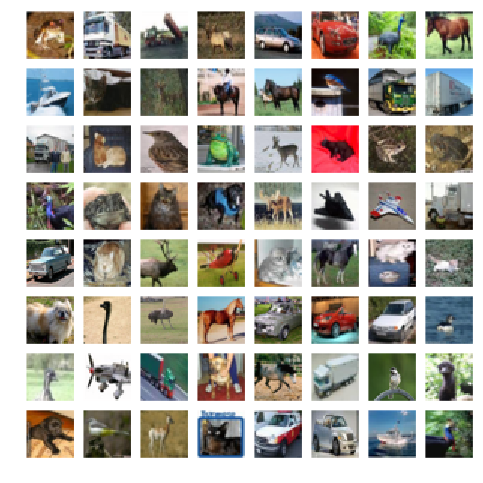

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 8))
for i in range(0, 64):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]), interpolation='none')

CIFAR-10 includes 50000 images for training and 10000 for test.

In [9]:
N = len(train_labels)
N_test = len(test_labels)

Import chainer and the dependencies.

In [10]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

If you use a gpu, set the gpu device value here.

In [11]:
gpu = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpu >= 0 else np

Describe the neural net architecture you want to train.

In [12]:
class CNN(chainer.Chain):
    
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(3, 64, ksize=3, pad=1),
            conv2 = L.Convolution2D(64, 64, ksize=3, pad=1),
            conv3 = L.Convolution2D(64, 128, ksize=3, pad=1),
            conv4 = L.Convolution2D(128, 128, ksize=3, pad=1),
            fc5 = L.Linear(8192, 1024),
            fc6 = L.Linear(1024, 10),
        )
    
    def __call__(self, x, t, train=True):
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss
    
    def forward(self, x, train=False):
        self.h_input = x
        self.h_conv1 = F.relu(self.conv1(self.h_input))
        self.h_conv2 = F.relu(self.conv2(self.h_conv1))
        self.h_pool2 = F.max_pooling_2d(self.h_conv2, ksize=2, stride=2)
        self.h_conv3 = F.relu(self.conv3(self.h_pool2))
        self.h_conv4 = F.relu(self.conv4(self.h_conv3))
        self.h_pool4 = F.max_pooling_2d(self.h_conv4, ksize=2, stride=2)
        self.h_fc5 = F.dropout(F.relu(self.fc5(self.h_pool4)), train=train)
        self.h_fc6 = self.fc6(self.h_fc5)
        return self.h_fc6

Set the optimizer. (MomentumSGD, AdaDelta, AdaGrad, Adam, ...)

In [13]:
model = CNN()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.to_gpu()

Define the 'test_net' function to get the accuracy of the validation data.

In [14]:
import sys
import progressbar as prg
batchsize = 100

def test(x, y):
    sum_accuracy = 0
    sum_loss = 0
    with prg.ProgressBar(max_value=len(y)) as bar:
        for i in six.moves.range(0, len(y), batchsize):
            bar.update(i + batchsize)
            x_batch = chainer.Variable(
                xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(
                xp.asarray(y[i:i + batchsize]), volatile='on')
            model(x_batch, t_batch, train=False)
            sum_loss += float(model.loss.data)
            sum_accuracy += float(model.accuracy.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(y), sum_accuracy * batchsize /len(y)

In [15]:
losses, test_its, test_losses, test_accs = ([] for i in range(4))
loss, acc = test(test_data, test_labels)
test_its.append(len(losses))
test_losses.append(loss)
test_accs.append(acc)
print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))

100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.46


test: loss=2.30098012686, accuracy=0.11189999938


We're going to train the model by using the training data `n_epoch` times.

In [16]:
n_epoch = 10
np.random.seed(777)

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    perm = np.random.permutation(N)
    with prg.ProgressBar(max_value=N) as bar:
        for i in six.moves.range(0, N, batchsize):
            bar.update(i)
            x = chainer.Variable(
                xp.asarray(train_data[perm[i:i + batchsize]]),  volatile='off')
            t = chainer.Variable(
                xp.asarray(train_labels[perm[i:i + batchsize]]),  volatile='off')
            optimizer.update(model, x, t)
            losses.append(float(model.loss.data))
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    test_its.append(len(losses))
    test_losses.append(loss)
    test_accs.append(acc)
    print('train: batch={}, loss={}'.format(
        str(i / batchsize + 1), str(float(model.loss.data))))
    print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))
    sys.stdout.flush()
    
    # save model
    model_filename = 'cnn-cifar10-epoch{0:d}.chainermodel'.format(epoch)
    serializers.save_hdf5(model_filename, model)

100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.05
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 0.99


('epoch', 1)
train: batch=500, loss=1.09798395634
test: loss=1.01583261847, accuracy=0.644800000191


100% (50000 of 50000) |######################| Elapsed Time: 0:00:17 Time: 17.97
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 2)
train: batch=500, loss=0.907091975212
test: loss=0.782792608738, accuracy=0.722900002003


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.12
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 0.96


('epoch', 3)
train: batch=500, loss=0.729469180107
test: loss=0.695395680666, accuracy=0.757399998307


100% (50000 of 50000) |######################| Elapsed Time: 0:00:17 Time: 17.92
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 0.97


('epoch', 4)
train: batch=500, loss=0.664486050606
test: loss=0.706166843772, accuracy=0.762200000286


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.61
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.03


('epoch', 5)
train: batch=500, loss=0.573646128178
test: loss=0.650302697718, accuracy=0.782299996614


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.30
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.07


('epoch', 6)
train: batch=500, loss=0.635082602501
test: loss=0.657883068919, accuracy=0.788799997568


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.48
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.03


('epoch', 7)
train: batch=500, loss=0.694316089153
test: loss=0.683412648439, accuracy=0.787499998808


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.38
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.01


('epoch', 8)
train: batch=500, loss=0.627168357372
test: loss=0.740061441958, accuracy=0.788699999452


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.02
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.03


('epoch', 9)
train: batch=500, loss=0.807796239853
test: loss=0.847241491973, accuracy=0.785799996257


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.03
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.04


('epoch', 10)
train: batch=500, loss=0.995080113411
test: loss=0.885204680562, accuracy=0.793999994993


Plot the losses and the accuracies.

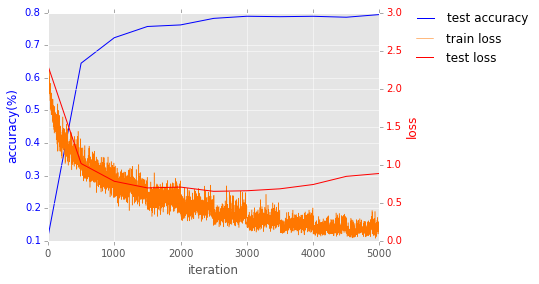

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(test_its, test_accs, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy(%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.48, 1.05), framealpha=0)
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ff7700')
ax2.plot(test_its, test_losses, 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0)
plt.tight_layout()
plt.show()

Now we achieved 64% accuracy after epoch 1, and 79% accuracy after epoch 10 in the validation data. Let's classify one of the data.

In [18]:
# force to use np.array for plotting filters, and feature maps
if gpu >= 0:
    model.to_cpu()
    xp = np

In [19]:
def predict(x, top=5):
    x = x.reshape(1, 3, 32, 32)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = list(zip(y_batch.data[0], label_names))
    results.sort(reverse=True)
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:12s} | {2:7.3f}%'.format(rank, name, float(score*100)))

label: ship
# 1| ship         |  89.769%
# 2| automobile   |  10.231%
# 3| airplane     |   0.000%
# 4| truck        |   0.000%
# 5| cat          |   0.000%


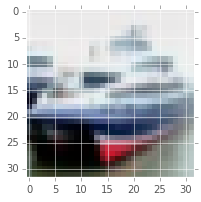

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(imdeprocess(test_data[1]), interpolation='none')
print('label: ' + label_names[test_labels[1]])
predict(test_data[1])

The 1st layer conv1 consist of 64 (3 color channels, 3x3 sized) filters.

(64, 3, 3, 3)


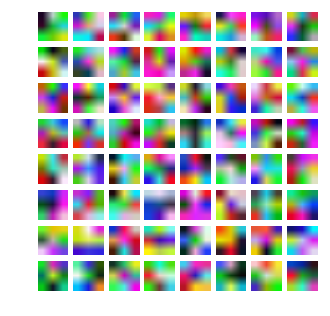

In [21]:
print(model.conv1.W.data.shape)
plt.figure(figsize=(5, 5))
for i in range(0, 64):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    fmap = model.conv1.W.data[i]
    plt.imshow(fmap.transpose((1, 2, 0)))

The feature maps of conv1. They've extracted various features, e.g. edges and colors.

(64, 32, 32)


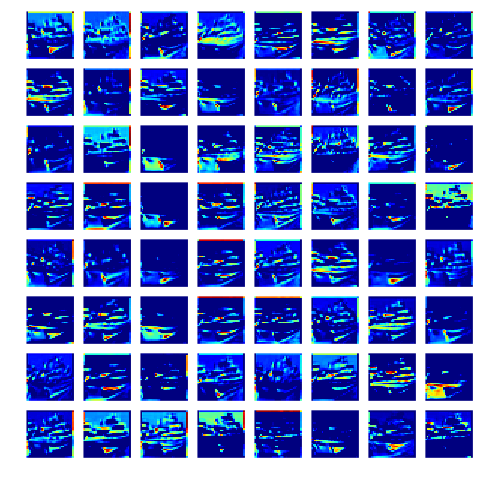

In [22]:
print(model.h_conv1.data[0].shape)
plt.figure(figsize=(8, 8))
for i in range(0, 64):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.imshow(model.h_conv1.data[0][i], interpolation='none')

The conv4 consist of 128 (128 channels, 3x3 sized) filters. We show only the first 16 channels of 16 filters.

(128, 128, 3, 3)


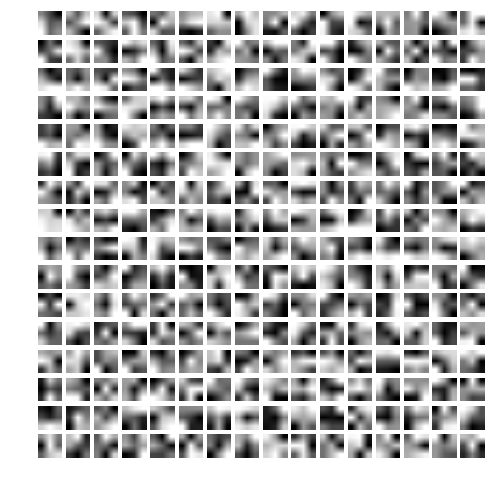

In [23]:
print(model.conv4.W.data.shape)
plt.figure(figsize=(8, 8))
for i in range(0, 16*16):
    plt.subplot(16, 16, i+1)
    plt.axis('off')
    fmap = model.conv4.W.data[int(i/16)][i%16]
    plt.imshow(fmap, cmap='gray')

The feature maps of conv4. We see the feature maps sparsely activated.

(128, 16, 16)


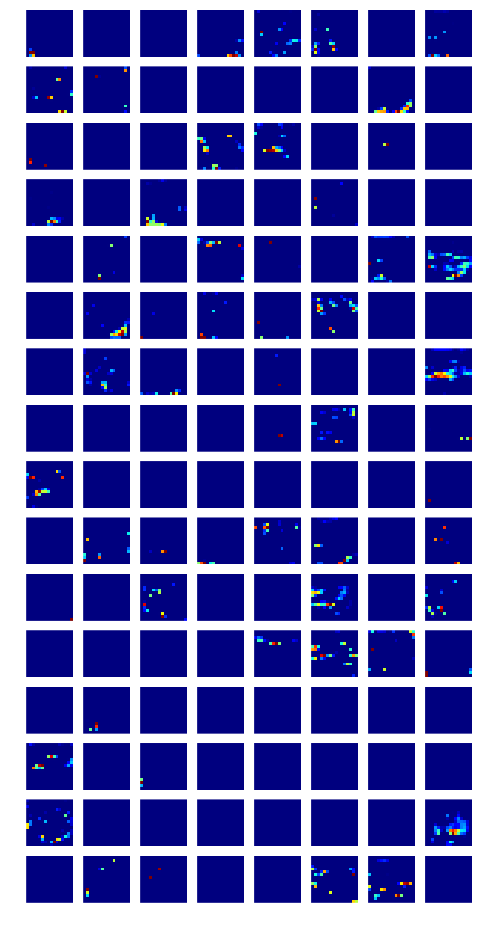

In [24]:
print(model.h_conv4.data[0].shape)
plt.figure(figsize=(8, 16))
for i in range(0, 128):
    plt.subplot(16, 8, i+1)
    plt.axis('off')
    plt.imshow(model.h_conv4.data[0][i], interpolation='none')